<a href="https://colab.research.google.com/github/Abdullahkitchlew/Machine-Learning/blob/main/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

IMAGE_SIZE = [224, 224]
input_shape=IMAGE_SIZE + [3]
train_path = '/content/drive/MyDrive/Colab Notebooks/pnemounia/chest_xray/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/pnemounia/chest_xray/test'
test_path = '/content/drive/MyDrive/Colab Notebooks/pnemounia/chest_xray/test'

In [ ]:
# train_data = tf.keras.preprocessing.image_dataset_from_directory(train_path, shuffle = True)
# val_data = tf.keras.preprocessing.image_dataset_from_directory(valid_path, shuffle = False)

image_size = 160
batch_size = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_path,image_size=(image_size, image_size), batch_size = batch_size,shuffle = True)
val_data = tf.keras.preprocessing.image_dataset_from_directory(valid_path,image_size=(image_size, image_size),batch_size = batch_size,shuffle = False)

Found 5217 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [ ]:
class_names = train_data.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


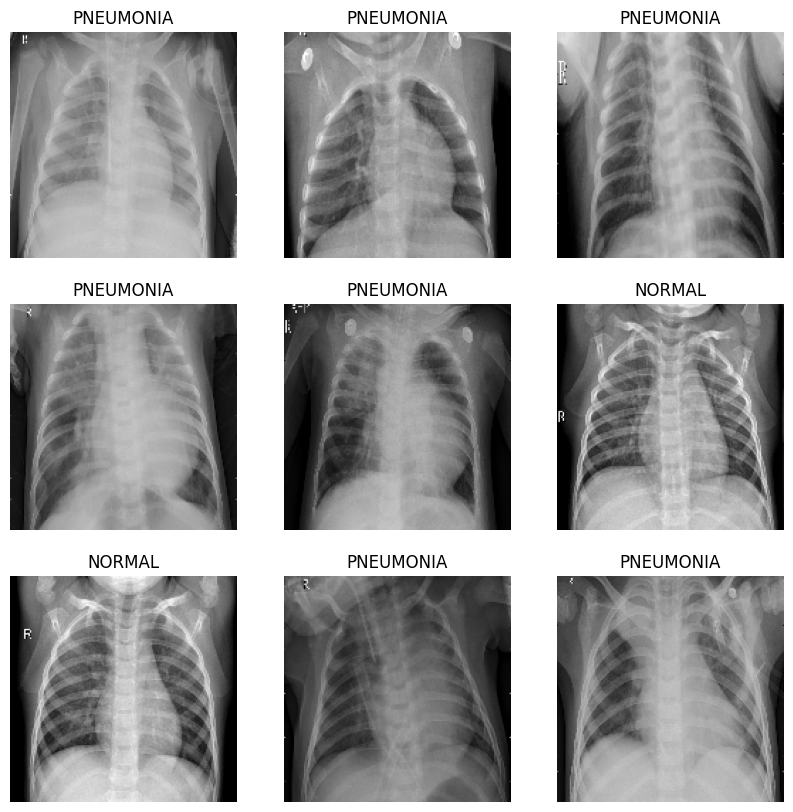

In [ ]:
plt.figure(figsize = (10,10))

for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

9.327528 251.53749


Image Normalization

In [ ]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) -1   # Between -1 to 1
    return image, label

In [ ]:
train = train_data.map(format_example)
validation = val_data.map(format_example)

In [ ]:
for normal_batch, normal_label_batch in train:
  print(normal_batch.shape)
  print(normal_label_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [ ]:
normal_image = normal_batch[0]
print(np.min(normal_image), np.max(normal_image))

-1.0 1.0


In [ ]:
IMG_SHAPE = ( image_size, image_size, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,  include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
base_model.trainable = True
len(base_model.layers)

154

In [ ]:
for layer in base_model.layers[:100]:
  layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
        base_model,
        global_average_layer,
        prediction_layer                     
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train,epochs=30, validation_data=validation)

Epoch 1/30
164/164 [==============================] - 47s 271ms/step - loss: 0.0165 - accuracy: 0.9952 - val_loss: 0.6585 - val_accuracy: 0.8317
Epoch 2/30
164/164 [==============================] - 42s 247ms/step - loss: 0.0109 - accuracy: 0.9971 - val_loss: 0.5922 - val_accuracy: 0.8478
Epoch 3/30
164/164 [==============================] - 43s 250ms/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 0.6640 - val_accuracy: 0.8301
Epoch 4/30
164/164 [==============================] - 43s 253ms/step - loss: 0.0072 - accuracy: 0.9987 - val_loss: 0.6324 - val_accuracy: 0.8381
Epoch 5/30
164/164 [==============================] - 42s 247ms/step - loss: 0.0044 - accuracy: 0.9996 - val_loss: 0.6254 - val_accuracy: 0.8494
Epoch 6/30
164/164 [==============================] - 41s 244ms/step - loss: 0.0041 - accuracy: 0.9996 - val_loss: 0.6621 - val_accuracy: 0.8349
Epoch 7/30
164/164 [==============================] - 42s 245ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.7293 - val_ac

In [ ]:
def plot_graghs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

  

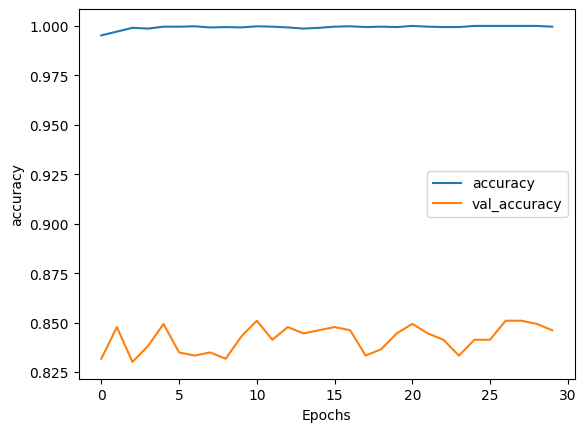

In [ ]:
plot_graghs(history, 'accuracy')

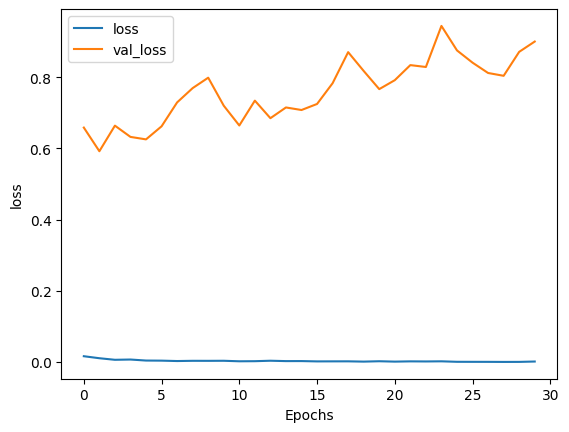

In [ ]:
plot_graghs(history, 'loss')

In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory( test_path, image_size=(image_size, image_size),batch_size = batch_size,shuffle=False)

Found 624 files belonging to 2 classes.


In [ ]:
result = model.evaluate(test_data)
print("Test loss, Test accuracy : ", result)

20/20 [==============================] - 3s 149ms/step - loss: 3.0882 - accuracy: 0.6250
Test loss, Test accuracy :  [3.0882163047790527, 0.625]
